# Build a Binary Machine Learning Classifier

The purpose of this notebook is to show the basic process of building, tuning and assessing the performance of a binary machine learning classifier

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import xgboost

# Local packages
import performance_metrics
import model_prep

### Load Data
Source: https://archive.ics.uci.edu/ml/datasets/bank+marketing

In [2]:
example_df = pd.read_csv('bank.csv', na_values=[np.nan])

# Drop features that are not meaningful for the analysis
drop_elements = ['ID', 'Unnamed: 0']
example_df = example_df.drop(drop_elements, axis=1)

# Basic NA cleaning

for col in example_df:
    dt = example_df[col].dtype
    if dt == int or dt == float:
        example_df[col].fillna(0)
    else:
        example_df[col].fillna('unknown')

### Encode, split and scale data 

**Encoding Categorical Features:** Python packages for machine learning typically only accept numerical features, so you need to encode your categorical features. There are two options: 
* 1) Represent each unique value as a number - not recommended as you introduce meaning to the order that doesn't exist; 
* 2) One-hot-encode each feature so that each unique value becomes a new binary feature (1=value, 0=not value)


In [3]:
# One-hot encoding of categorical features - note, data should only contain features and target

example_df = model_prep.one_hot_encode(df=example_df)

**Split into train/test:** To test the performance of your trained model, you need to split your data into a training  and a test set. A common split is 80% to training, 20% to test, but this depends on your sample size.

In [4]:
# Split data into train and test, convert the target to 1=positive class, 0=negative class

Y = example_df['Y_2'].map(lambda x: 0 if x == 1 else 1 if x == 2 else -1)
x = example_df.drop('Y_2', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.2, stratify=Y, random_state=26)

**Scale:** If some features have a larger variance than others, it can result in them dominating the objective function, making it harder to learn from the other features. To avoid this, we scale all features to have mean=0 and unit variance.

In [5]:
# Scale data
scl = StandardScaler()
x_train_scaled = scl.fit_transform(x_train)
x_test_scaled = scl.transform(x_test)

## Hyper-parameter tuning

Hyper-parameters are settings for the training process that you can adjust to better fit your model to the data. To maximise performance, these parameters need to be tuned to find their optimal values. This is done by setting a search space for each parameter and then testing with cross-validation all the different combinations to find the combination with the highest performance. For the full list of parameters see: http://xgboost.readthedocs.io/en/latest//parameter.html

If you are running this on a single machine, I recommend using a two-step approach to hyper-parameter tuning to limit the number of combinations:
* 1) Do a course search (demonstrated below) to find the rough optimal regions for each parameter
* 2) Do a more fine search (reduce the intervals) around the optimal values returned in step 1

***Warning: This will run all combinations of the parameters so it may take some time***

In [6]:
xgb = xgboost.XGBClassifier(n_estimators=1000)
scale_target = sum(np.argwhere(y_train == 0))/sum(np.argwhere(y_train == 1))

tuning_params = [{'max_depth': [5, 10],
                  'colsample_bytree': [0.5, 0.7],
                  'subsample': [0.5, 0.7],
                  'max_delta_step': [0, 5],
                  'gamma': [0, 5, 10],
#                   'min_child_weight': [1, 5],
#                   'scale_pos_weight': [1, scale_target[0]/2, scale_target[0]],
#                   'reg_alpha': [0, 0.01],
                  'learning_rate': [0.01, 0.1]
                 }]

clf = GridSearchCV(xgb, tuning_params, scoring='roc_auc')
clf.fit(x_train_scaled, y_train)
print('\nBest Parameters:')
print(clf.best_params_)
print('\nCross-validation results:\n')
print(clf.cv_results_)
print('\nDetailed report:\n')
y_true, y_predicted = y_test, clf.predict(x_test_scaled)
print(classification_report(y_true, y_predicted))


Best Parameters:
{'colsample_bytree': 0.7, 'gamma': 5, 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 10, 'subsample': 0.7}

Cross-validation results:

{'split0_test_score': array([ 0.93638572,  0.93625915,  0.93608687,  0.93508733,  0.93638572,
        0.93625915,  0.93608687,  0.93508733,  0.92465321,  0.9255646 ,
        0.92633987,  0.92703251,  0.92465321,  0.9255646 ,  0.92633987,
        0.92703251,  0.93483217,  0.9350371 ,  0.93780416,  0.93751862,
        0.93483217,  0.9350371 ,  0.93780416,  0.93751862,  0.93383916,
        0.93567751,  0.93405364,  0.93412747,  0.93383916,  0.93567751,
        0.93405364,  0.93412747,  0.9300369 ,  0.93128306,  0.93319574,
        0.93447756,  0.9300369 ,  0.93128306,  0.93319574,  0.93447756,
        0.93532641,  0.93643796,  0.93748948,  0.93682195,  0.93532641,
        0.93643796,  0.93748948,  0.93682195,  0.93719188,  0.9369543 ,
        0.93625262,  0.93618381,  0.93719188,  0.9369543 ,  0.93625262,
        0.93618381,  0.

In [7]:
# Train strongest model based on tuning
xgb = xgboost.XGBClassifier(**clf.best_params_)

xgb.fit(x_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=5, learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

## Assess the Performance

There are many metrics available to assess the performance of your model. While the metrics you choose will be dependent on the problem and norms in your field, each has its own benefits and weaknesses so it is best not to rely on just one. Visual analysis can also be useful for understanding the performance of your model and trade-offs that can be made. In the next section we will produce the following metrics and plots using a local package.

**Performance Metrics (possible range, objective):**
* Accuracy (0:1, maximise) - the proportion of predictions that were correct (taking into account both classes)
* F1 (0:1, maximise) - Weighted average of precision and recall
* Recall (0:1, maximise) - Of those actually in a given class, the proportion that are correctly predicted (i.e. how much you 'pick up')
* Precision (0:1, maximise) - Of those predicted as a given class, the proportion that are correct (i.e. 1- precision is the error in your predictions for that class)
* ROC_AUC (0:1, maximise) - The Receiver Operating Characteristic (ROC) curve compares the true positive rate (correct positive / total positive) to the false positive rate (1-(correct negative predictions/total negative)). The larger the area under the curve (AUC), the lower the false positive rate is compared to the true positive rate, and therefore the more predictive the model is. The worst case is a diagonal line (ROC_AUC=0.5), meaning the true positive rate and false positive rate are equal at each point, and the model is no better than randomly assigning labels. If ROC_AUC is less than 0.5, switch the target values.
* Gini Co-efficient (0:1, maximise) - The gini coefficient measure the inequality among values of a frequency distribution, or purity, and can be derived from the ROC_AUC. If the model is random (ROC_AUC = 0.5), gini will equal 0. The higher the gini, the better the model.
* Log Loss (0:1, minimise) -  The logistic loss, or negative log-likelihood of the true labels, increases as the predicted probability diverges from the actual label. Log loss takes into account the uncertainty of your prediction,  so if a classification is wrong and the probability was high, it will be penalised more than if the probability was lower.

In [8]:
target_names = ['reject', 'accept']
performance_df = performance_metrics.performance_metrics(clf=xgb, x_test=x_test_scaled, y_test=y_test, target_names=target_names)


Key Metrics:
accuracy               0.843
f1                     0.842
f1_weighted            0.842
gini_coefficient       0.826
log_loss               0.476
precision_pos_class    0.815
recall_pos_class       0.886
roc_auc                0.913
roc_auc_weighted       0.913
dtype: float64

Classification Report:
             precision    recall  f1-score   support

     reject       0.87      0.80      0.84      1058
     accept       0.82      0.89      0.85      1058

avg / total       0.85      0.84      0.84      2116



**Performance Plots:**
* Confusion Matrix - compares the predicted labels to the actual labels
* Precision-Recall Curve - compares precision and recall
* ROC Curve - compares the true positive rate to the false positive rate
* FPR, TPR by Probability Threshold - compares the true positive and false positive rates at different thresholds of probability (i.e. what happens if I don't go with the default 0.5 cut-off)
* Lift - shows the proportion of correct predictions in the positive class for each percentile of the population when you sort the data by the probability for the positive class (high to low). A good model will have a higher proportion of the positive class than that of the population overall in the early percentiles (where probability is highest).
* Gain - Without a model, you expect to see 10% of the positive class in each 10% of the population you randomly select. This plot shows the cumulative proportion of the positive class captured for each 10% of the population added when the data is sorted by the probability for the positive class (high to low). The further the curve is away from the diagonal (baseline), the better the model is at predicting the positive class. 

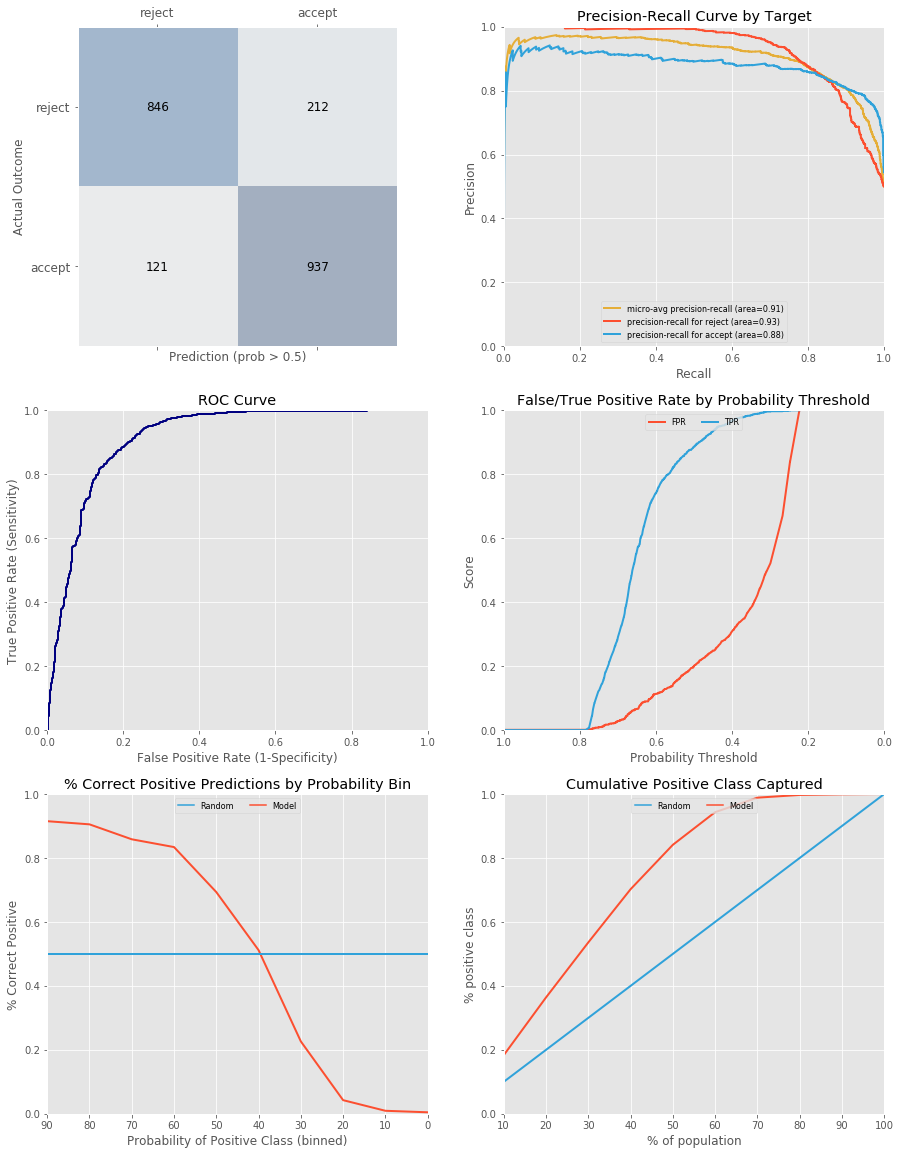

In [9]:
performance_plots = performance_metrics.performance_plots(clf=xgb, x_test=x_test_scaled, y_test=y_test, target_names=target_names)